In [1]:
import pods, pandas as pd, os

In [2]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from matplotlib import pyplot as plt
#import pygraphviz

In [3]:
import GPy, numpy as np
from GPy.models import BayesianGPLVM

In [4]:
# This is the process of how we loaded the data:
ulabels = ['Zygote', 
           '2-cell embryo', 
           'Early 2-cell blastomere', 'Mid 2-cell blastomere', 'Late 2-cell blastomere',
           '4-cell blastomere', '8-cell blastomere', '16-cell blastomere',
           'Early blastocyst cell', 'Mid blastocyst cell', 'Late blastocyst cell',
           'fibroblast', 
           'adult liver',
          ]

folder_path = 'Deng'
csv_file = os.path.join(folder_path, 'expression_values.csv')
if os.path.exists(csv_file):
    Ydata = pd.read_csv(csv_file, index_col=[0,1,2], header=0)
else:
    data = GPy.util.datasets.singlecell_rna_seq_deng()
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    Ydata = data['Y'].copy()
    Ydata.columns = Ydata.columns.to_series().apply(str.upper)
    Ydata = Ydata.reset_index().set_index('index', append=True)
    Ydata['labels'] = data['labels'].values
    Ydata = Ydata.set_index('labels', append=True)
    Ydata = Ydata.reorder_levels([0,2,1])
    Ydata = Ydata.reset_index([0,2]).loc[ulabels].set_index(['level_0', 'index'], append=True)
    Ydata.to_csv(csv_file)

In [5]:
from topslam.filtering import filter_RNASeq

In [6]:
Y = Ydata.copy()
Y.columns = [c.split('.')[0] for c in Y.columns]

# take only the cellcycle genes, for maximum coverage of time line
# Take cellcycle genes from Macosko et al. 2015
# converted by the DAVID (from OFFICIAL_GENE_SYMBOL to ENSEMBL_GENE_ID)
#cellcycle_conversion = pd.read_csv('Trapnell/MacoskoCCConversionENS.txt', sep='\t')
#cellcycle_filter = np.intersect1d(cellcycle_conversion.From.apply(str.upper), Y.columns.to_series().apply(str.upper))
#Y = Y[cellcycle_filter]

Y = filter_RNASeq(Y)

Before filtering: #cells=317 #genes=22958
After filtering: #cells=317 #genes=376
Transforming the data Y = log(E + 1)


In [7]:
labels = Y.index.get_level_values(0).values

# Fix the 8cell state, as one batch seems to be extremely out of place
new_8_labels = []
for _l in Y.loc['8-cell blastomere'].index.get_level_values(1):
    _l = _l.split('-')[0]
    if not('split' in _l):
        new_8_labels.append('8')
    elif not('pooled' in _l):
        new_8_labels.append('8 split')
    else:
        new_8_labels.append('8 split')

labels[labels=='8-cell blastomere'] = new_8_labels

# Fix the 8cell state, as one batch seems to be extremely out of place
new_16_labels = []
for _l in Y.loc['16-cell blastomere'].index.get_level_values(1):
    _l = _l.split('-')[0]
    if not('split' in _l):
        new_16_labels.append('16')
    elif not('pooled' in _l):
        new_16_labels.append('16 split')
    else:
        new_16_labels.append('16 split')

labels[labels=='16-cell blastomere'] = new_16_labels

ulabels = []
for lab in labels:
    if lab not in ulabels:
        ulabels.append(lab)

In [8]:
short_labels = labels.copy()
_ulabels_convert = np.array([
        'Z',# Z',
        'E',# Em',
        '2',# Bm E',
        '2',# Bm M',
        '2',# Bm L',
        '4',
        '8',
        '8 s',
        '16',
        '16 s',
        'Bz',# E',
        'Bz',# M',
        'Bz',# L'
        'F',
        'L'
    ])

short_ulabels = []
for lab, nlab in zip(ulabels, _ulabels_convert):
    short_labels[short_labels==lab] = nlab
    if nlab not in short_ulabels:
        short_ulabels.append(nlab)

In [9]:
Y_m = Y.values

In [10]:
from topslam.optimization import methods, create_model, optimize_model, run_methods

X_init, dims = run_methods(Y_m, methods)

In [11]:
if 0:
    m = create_model(Y_m, X_init, num_inducing=25)
    optimize_model(m)
    m.pickle('Deng/deng_model.pickle')
else:
    m = GPy.load('Deng/deng_model.pickle')

In [12]:
from topslam import ManifoldCorrectionKNN, ManifoldCorrectionTree
import networkx as nx, pandas as pd

In [13]:
r = lambda x: x.reshape(res, res).T

 /home/maxz/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


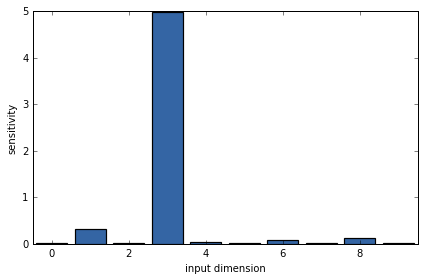

In [14]:
m.kern.plot_ARD()

In [15]:
msi = m.get_most_significant_input_dimensions()[:2]

start = 0

mc = ManifoldCorrectionTree(m, dimensions=msi)
pseudo_time = mc.get_pseudo_time(start)

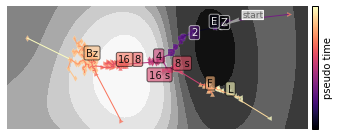

In [17]:
fig, ax = plt.subplots(figsize=(5,2))
mc.plot_waddington_landscape(ax=ax)
mc.plot_graph_nodes(short_labels, short_ulabels, start=start, ax=ax)
mc.plot_graph_labels(short_labels, short_ulabels, start=start, ax=ax, box=True)
mc.plot_time_graph_edges(start=start, ax=ax, startoffset=(20,10))

#from adjustText import adjust_text
#adjust_text(ax.texts[:-1], arrowprops=dict(arrowstyle="fancy",
#                                        fc="r", ec="none",
#                                        #patchB=el,
#                                        #connectionstyle="angle3,angleA=17,angleB=-90"
#                                             ))

fig.tight_layout()
fig.savefig('../diagrams/Deng/Manifold_Tree_deng.pdf', transparent=True, bbox_inches='tight')

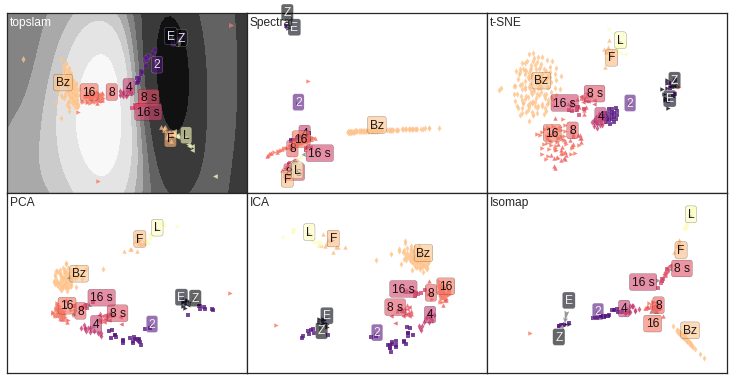

In [16]:
from topslam.plotting import plot_comparison
import seaborn as sns
sns.set_style('white')
fig, axes = plot_comparison(mc, X_init, dims, short_labels, short_ulabels, start)
#axes[0,0].legend(bbox_to_anchor=(0,1.02,3,.102), mode='expand', 
#                 ncol=len(short_ulabels), loc=3, borderaxespad=0,
#                 handletextpad=-.3,
#                 scatteryoffsets=[.5],)
fig.tight_layout(pad=0, w_pad=.01, h_pad=.03, rect=(0,0,1,1))
fig.savefig('../diagrams/Deng/method_comparison_deng.pdf', transparent=True, bbox_inches='tight')